In [2]:
# Import dependencies
# Graphs currently unavailable in this set because of experimental Graph library hiddenlayer
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt # for plotting graphs
from functools import cmp_to_key

from sklearn import metrics
import math
import tensorflow as tf
from tensorflow.python.data import Dataset
import hiddenlayer as hl
import time
import random

# A History object to store metrics
history1 = hl.History()
# A Canvas object to draw the metrics
canvas1 = hl.Canvas()

tf.logging.set_verbosity(tf.logging.ERROR)


In [3]:
# load the train.csv file
df = pd.read_csv('train.csv')
df = df.reindex()
df_test = pd.read_csv('test.csv')
numerical_fields = [
    'LotArea', 'OverallQual', 'YearBuilt', 'TotRmsAbvGrd', 'YrSold', 'OverallCond', 'PoolArea'
]

categorical_fields = [
    'Neighborhood', 'SaleCondition', 'MSZoning', 
]


In [4]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
    input_features: The names of the numerical input features to use.
    Returns:
    A set of feature columns
    """
    return set([tf.feature_column.numeric_column(my_feature)
                for my_feature in input_features])

#Modified one_hot encoding to replace NA's
def get_dummies(dummy_na = False):
    def wrapper_get_dummies(s):
        df = pd.get_dummies(s, prefix = s.name, dummy_na = dummy_na)
        df1 = pd.DataFrame()
        for k in df.keys():
            s = df[k]
            name = s.name
            name = name.replace('(', '')
            name = name.replace(')', '')
            name = name.replace(' ', '')
            s1 = s.rename(name)
            df1[s1.name] = s1
        return df1
    return wrapper_get_dummies

def convert_features(df, num_fields, cat_fields, num_fields_proc = None, cat_fields_proc = None, label_name = None, train_validate_ratio = None):
    if num_fields_proc is None:
        num_fields_proc = lambda x: x
    if cat_fields_proc is None:
        cat_fields_proc = lambda x: x
    features = pd.DataFrame()
    for k in num_fields:
        features[k] = num_fields_proc(df[k].copy())
    for k in cat_fields:
        features = features.join(cat_fields_proc(df[k].copy()))
    if label_name is not None:
        labels = df[label_name].copy()
    else:
        labels = None
    if train_validate_ratio is None:
        train_validate_ratio = 1
    train_num = int(len(df) * train_validate_ratio)
    validate_num = len(df) - train_num
    train_features = features.head(train_num)
    validate_features = features.tail(validate_num)
    if labels is not None:
        train_labels = labels.head(train_num)
        validate_labels = labels.tail(validate_num)
    else:
        train_labels = None
        validate_labels = None
    return (train_features, train_labels, validate_features, validate_labels)

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.

    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """

    # Convert pandas data into a dict of np arrays.
    # features = {key:np.array(value) for key,value in dict(features).items()}                                            

    #
    # note: can convert to dict directly
    #
    features = dict(features)


    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)

    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def my_input_fn_pred(features, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.

    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """

    # Convert pandas data into a dict of np arrays.
    # features = {key:np.array(value) for key,value in dict(features).items()}                                            

    #
    # note: can convert to dict directly
    #
    features = dict(features)


    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices(features) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)

    # Return the next batch of data.
    features = ds.make_one_shot_iterator().get_next()
    return features

def train_dnn_regressor_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a DNN regression model.

    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.

    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.

    Returns:
    A `LinearRegressor` object trained on the training data.
    """
    if validation_examples is not None and validation_targets is not None:
        do_validation = True
    else:
        do_validation = False
    
    periods = 50
    steps_per_period = steps / periods

    # Create a linear regressor object.
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer
    )

    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets, 
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                    training_targets, 
                                                    num_epochs=1, 
                                                    shuffle=False)
    if do_validation == True:
        predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                          validation_targets, 
                                                          num_epochs=1, 
                                                          shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE, RMSLE (on training data):")
    training_rmse = []
    validation_rmse = []
    training_rmsle = []
    validation_rmsle = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )

        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        # Compute training loss RMSE.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_targets, training_predictions))

        # Compute training loss RMSLE.
        training_root_mean_squared_log_error = math.sqrt(
            metrics.mean_squared_log_error(training_targets, training_predictions))
        
        if do_validation == True:
            validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
            validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

            # Compute validation loss RMSE.
            validation_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(validation_targets, validation_predictions))

            # Compute validation loss RMSLE.
            validation_root_mean_squared_log_error = math.sqrt(
                metrics.mean_squared_log_error(validation_targets, validation_predictions))

        # Occasionally print the current loss.
        print("  period %02d : %0.2f, %0.4f" % (period, training_root_mean_squared_error, training_root_mean_squared_log_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        training_rmsle.append(training_root_mean_squared_log_error)
        if do_validation == True:
            validation_rmse.append(validation_root_mean_squared_error)
            validation_rmsle.append(validation_root_mean_squared_log_error)
        
        # Store metrics in the history object
        history1.log(period, rmse=training_root_mean_squared_error, rmsle=training_root_mean_squared_log_error)

        # Plot the two metrics in one graph
        canvas1.draw_plot([history1["RMSE"], history1["RMSLE"]])
        time.sleep(0.1)
 
    print("Model training finished.")
    return dnn_regressor

In [5]:
ret = convert_features(df, 
                       numerical_fields, 
                       categorical_fields, 
                       num_fields_proc = None, 
                       cat_fields_proc = get_dummies(categorical_fields),
                       label_name = 'SalePrice',
                       train_validate_ratio = 0.9)

training_features = ret[0]
training_targets = ret[1]
validation_features = ret[2]
validation_targets = ret[3]

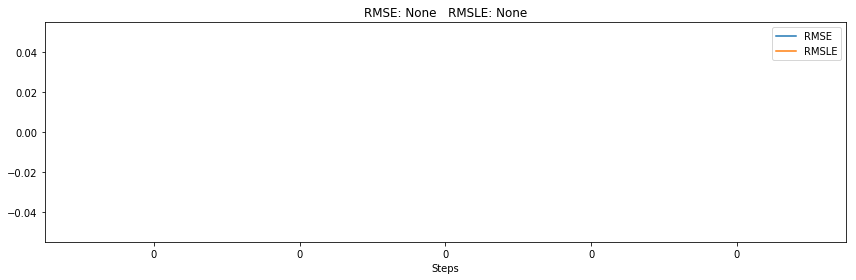

KeyboardInterrupt: 

In [7]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
dnn_regressor = train_dnn_regressor_model(
    optimizer,
    steps=100,
    batch_size=100,
    #hidden_units=[100,20,44,11],
    hidden_units=[20],
    training_examples=training_features,
    training_targets=training_targets,
    validation_examples=validation_features,
    validation_targets=validation_targets)

In [ ]:
ret = convert_features(df_test, 
                       numerical_fields, 
                       categorical_fields, 
                       num_fields_proc = None, 
                       cat_fields_proc = get_dummies(dummy_na = True),
                       label_name = None,
                       train_validate_ratio = 1.0)

test_features = ret[0]

# fill missing values with 0.0
for k in test_features.keys():
    s = test_features[k]
    na_cnt = sum(s.isna())
    if na_cnt > 0:
        test_features[k] = s.fillna(0.0)

predict_test_input_fn = lambda: my_input_fn_pred(test_features,
                                                 num_epochs=1, 
                                                 shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_test_input_fn)
df_submit = pd.DataFrame()
df_submit['Id'] = df_test['Id']
df_submit['SalePrice'] = np.array([item['predictions'][0] for item in test_predictions])

df_submit.to_csv('./test_prediction-2.csv', index = False)